In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import sys
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from FLharmony import Client, Center, FL_harmonize
from FLKmeans import kfed
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import harmonypy as hm
import FedPCA.horizontal_pca_power_iteration as h
from sklearn.metrics.cluster import adjusted_rand_score

## Federated Harmony

In [4]:
PBMC_ZS = pd.read_csv('data/PBMC_ZS.csv') #d×N
batch =  pd.read_csv('data/PBMC_ZS_batch.csv') #N×1

In [5]:
# Normalize data
adata_ZS = ad.AnnData(PBMC_ZS.T) #N×d
sc.pp.normalize_total(adata_ZS, target_sum=1e4) # Can be done Locally
sc.pp.log1p(adata_ZS) # Can be done Locally
sc.pp.scale(adata_ZS, max_value=10) # Need aggregate \mu and calculate variance

/Users/ry/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
# Federated PCA
# split data into to different sets based on batch
data_list = []
for cluster in batch['x'].unique(): # Here 'x' should be replaced by the column name of batch in batch dataset
    data_list.append(np.array(adata_ZS.X)[batch[batch['x'] == cluster].index])

# reduce to 20 dimension
k = 20 # number of dimension after FedPCA
x, e, count = h.simulate_distributed_horizontal(data_list, k, maxit=500)
proj = np.dot(adata_ZS.X, x)

converged: 420


In [7]:
# Split data into different site(batch)
clustered_data = {}
for cluster in batch['x'].unique(): # Here 'x' should be replaced by the column name of batch in batch dataset
    # Use boolean indexing to select rows where the cluster matches
    clustered_data[cluster] = proj[batch[batch['x'] == cluster].index]

In [8]:
# Simulate each site

client_list = [Client(Zi=clustered_data[cluster].T) for cluster in batch['x'].unique()]
# client_sample_1 = Client(Zi=clustered_data['Sample 1'].T) #d×N1
# client_sample_2 = Client(Zi=clustered_data['Sample 2'].T) 
# client_sample_3 = Client(Zi=clustered_data['Sample 3'].T)
# client_sample_4 = Client(Zi=clustered_data['Sample 4'].T)
# client_sample_5 = Client(Zi=clustered_data['Sample 5'].T)
# client_list = [client_sample_1, client_sample_2, client_sample_3, client_sample_4, client_sample_5]
client_list

In [9]:
# Federated Kmeans
N = PBMC_ZS.shape[1]
nclust = np.min([np.round(N / 30.0), 100]).astype(int)
k_dev = round((nclust/len(data_list)))+1
data_list = [client.Z_cos.T for client in client_list]
local_estimates, centroids_central = kfed(data_list, k_dev , nclust)

/Users/ry/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ry/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ry/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ry/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ry/anaconda3/lib/python3.

In [10]:
# give index to each client
for i in range(len(client_list)):
    client_list[i].index = i

# 2. define center
center = Center(centroids_central.T, client_list)

In [11]:
# FL_harmonize(client_list, center, number_of_harmony, number_of_kmeans)
FL_harmonize(client_list, center, 50, 20)

# Obtain the FedHarmony results of each site
res_PBMC_Fed = pd.DataFrame(np.concatenate([client.Z_corr for client in client_list], axis = 1))
res_PBMC_Fed.columns = ['X{}'.format(i + 1) for i in range(res_PBMC_Fed.shape[1])]

2024-04-10 14:20:37,468 - harmonypy - INFO - Iteration 1 of 50
2024-04-10 14:20:37,468 - harmonypy - INFO - Iteration 1 of 50
2024-04-10 14:20:39,646 - harmonypy - INFO - Iteration 2 of 50
2024-04-10 14:20:39,646 - harmonypy - INFO - Iteration 2 of 50
2024-04-10 14:20:41,742 - harmonypy - INFO - Iteration 3 of 50
2024-04-10 14:20:41,742 - harmonypy - INFO - Iteration 3 of 50
2024-04-10 14:20:44,084 - harmonypy - INFO - Iteration 4 of 50
2024-04-10 14:20:44,084 - harmonypy - INFO - Iteration 4 of 50
2024-04-10 14:20:46,277 - harmonypy - INFO - Iteration 5 of 50
2024-04-10 14:20:46,277 - harmonypy - INFO - Iteration 5 of 50
2024-04-10 14:20:48,352 - harmonypy - INFO - Iteration 6 of 50
2024-04-10 14:20:48,352 - harmonypy - INFO - Iteration 6 of 50
2024-04-10 14:20:50,445 - harmonypy - INFO - Iteration 7 of 50
2024-04-10 14:20:50,445 - harmonypy - INFO - Iteration 7 of 50
2024-04-10 14:20:52,549 - harmonypy - INFO - Iteration 8 of 50
2024-04-10 14:20:52,549 - harmonypy - INFO - Iteration 

/var/folders/_c/414cc1c12ml62pm7zglfcxx40000gn/T/ipykernel_77230/3746245808.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding_PBMC_Fed[mask, 0], embedding_PBMC_Fed[mask, 1], alpha=0.7, s=1, c=colors[group], label=group)


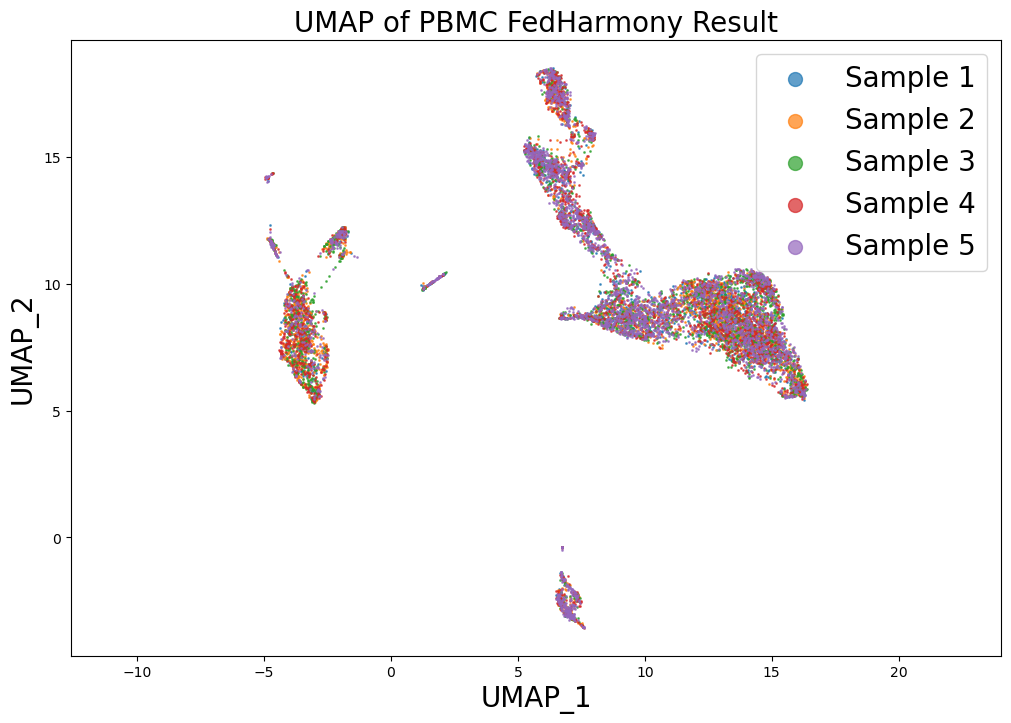

In [12]:
# Plot the umap
reducer = umap.UMAP()
embedding_PBMC_Fed = reducer.fit_transform(res_PBMC_Fed.T)

groups = batch['x'].unique()
# Color mapping
colors = {"Sample 1": sns.color_palette()[0], "Sample 2": sns.color_palette()[1], "Sample 3": sns.color_palette()[2], "Sample 4": sns.color_palette()[3], "Sample 5": sns.color_palette()[4]}
plt.figure(figsize=(12, 8))
for group in groups:
    mask = batch['x'] == group
    plt.scatter(embedding_PBMC_Fed[mask, 0], embedding_PBMC_Fed[mask, 1], alpha=0.7, s=1, c=colors[group], label=group)
plt.gca().set_aspect('equal', 'datalim')
plt.legend(fontsize=20, markerscale=10)
plt.title('UMAP of PBMC FedHarmony Result', fontsize = 20)
plt.xlabel('UMAP_1', fontsize = 20)
plt.ylabel('UMAP_2', fontsize = 20)
plt.savefig('/Users/ry/Desktop/Pitt/FL/FedHarmony/results/UMAP_PBMC_FedHarmony.png', dpi=300, bbox_inches='tight')

plt.show()

## Harmony

In [13]:
# PCA
sc.tl.pca(adata_ZS, n_comps=20)
# Harmony
ho = hm.run_harmony(adata_ZS.obsm['X_pca'], batch, 'x', max_iter_harmony=50)

2024-04-10 14:21:51,104 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-10 14:21:51,104 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-10 14:21:54,072 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-10 14:21:54,072 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-10 14:21:54,122 - harmonypy - INFO - Iteration 1 of 50
2024-04-10 14:21:54,122 - harmonypy - INFO - Iteration 1 of 50
2024-04-10 14:21:56,319 - harmonypy - INFO - Iteration 2 of 50
2024-04-10 14:21:56,319 - harmonypy - INFO - Iteration 2 of 50
2024-04-10 14:21:58,869 - harmonypy - INFO - Iteration 3 of 50
2024-04-10 14:21:58,869 - harmonypy - INFO - Iteration 3 of 50
2024-04-10 14:22:01,805 - harmonypy - INFO - Iteration 4 of 50
2024-04-10 14:22:01,805 - harmonypy - INFO - Iteration 4 of 50
2024-04-10 14:22:04,293 - harmonypy - INFO - Iteration 5 of 50
2024-04-10 14:22:04,293 - harmonypy - INFO - Iteration 5 of 50
2024-04-

/var/folders/_c/414cc1c12ml62pm7zglfcxx40000gn/T/ipykernel_77230/2800732038.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding_PBMC[mask, 0], embedding_PBMC[mask, 1], alpha=0.7, s=1, c=colors[group], label=group)


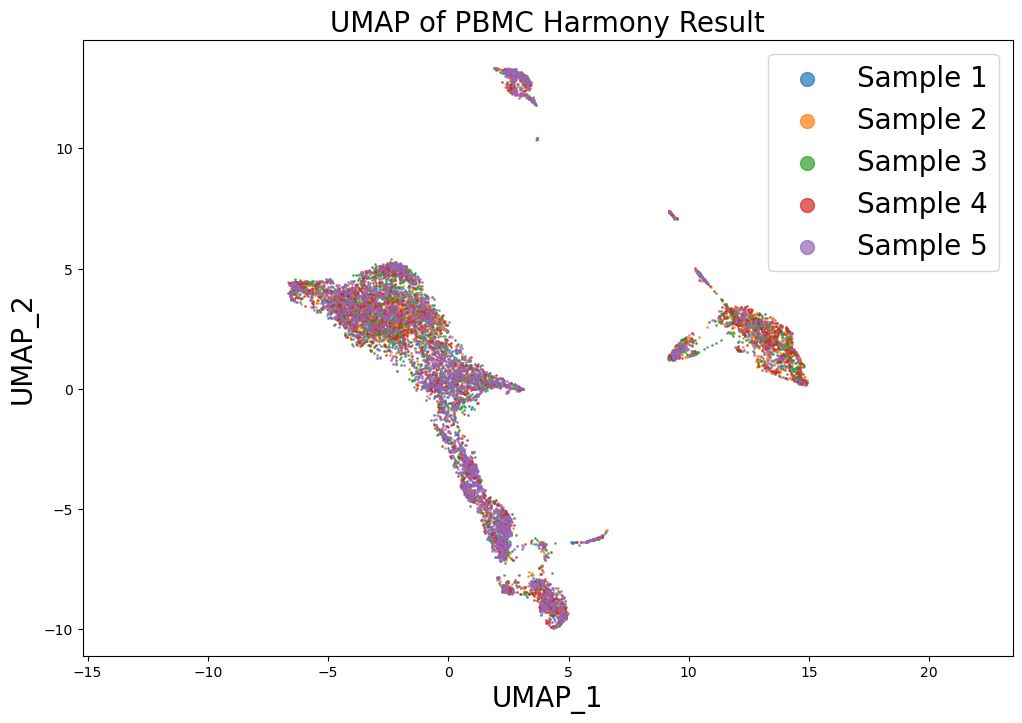

In [14]:
# Obtain Harmony results
res_PBMC = pd.DataFrame(ho.Z_corr)
res_PBMC.columns = ['X{}'.format(i + 1) for i in range(res_PBMC.shape[1])]

# Plot Umap
reducer = umap.UMAP()
embedding_PBMC = reducer.fit_transform(res_PBMC.T)

groups = batch['x'].unique()
# Color mapping
colors = {"Sample 1": sns.color_palette()[0], "Sample 2": sns.color_palette()[1], "Sample 3": sns.color_palette()[2], "Sample 4": sns.color_palette()[3], "Sample 5": sns.color_palette()[4]}
plt.figure(figsize=(12, 8))
for group in groups:
    mask = batch['x'] == group
    plt.scatter(embedding_PBMC[mask, 0], embedding_PBMC[mask, 1], alpha=0.7, s=1, c=colors[group], label=group)
plt.gca().set_aspect('equal', 'datalim')
plt.legend(fontsize=20, markerscale=10)
plt.title('UMAP of PBMC Harmony Result', fontsize = 20)
plt.xlabel('UMAP_1', fontsize = 20)
plt.ylabel('UMAP_2', fontsize = 20)
plt.savefig('/Users/ry/Desktop/Pitt/FL/FedHarmony/results/UMAP_PBMC_Harmony.png', dpi=300, bbox_inches='tight')
plt.show()

## ARI Comparision

In [15]:
ari_PBMC = []
for i in range(2, 11):
    kmeans_PBMC_Harmony = KMeans(n_clusters=7, init='k-means++', n_init=50).fit(res_PBMC.T)
    kmeans_PBMC_FedHarmony = KMeans(n_clusters=7, init='k-means++', n_init=50).fit(res_PBMC_Fed.T)
    ari_PBMC.append(adjusted_rand_score(kmeans_PBMC_Harmony.labels_, kmeans_PBMC_FedHarmony.labels_))
ari_PBMC

[0.9871464503477592,
 0.9853916775911573,
 0.9806963429271758,
 0.9840313565164293,
 0.9782538508905294,
 0.986322249973448,
 0.9780104806937452,
 0.9811387691832703,
 0.987062994146892]

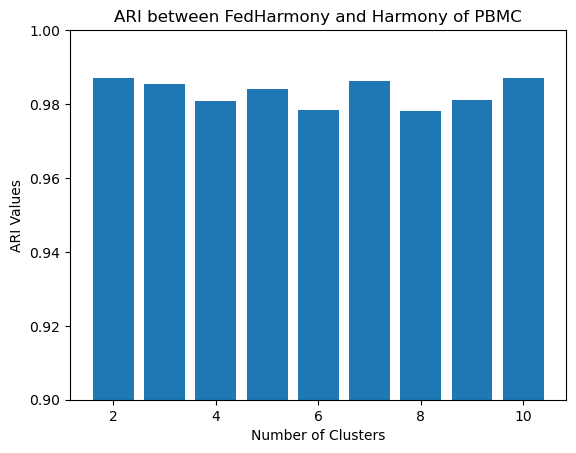

In [16]:
plt.title('ARI between FedHarmony and Harmony of PBMC')
plt.xlabel('Number of Clusters')
plt.ylabel('ARI Values')
plt.bar(range(2,11), ari_PBMC)
plt.ylim(bottom=0.9,top=1)
plt.savefig('/Users/ry/Desktop/Pitt/FL/FedHarmony/results/ARI PBMC.png', dpi=300, bbox_inches='tight')
